In [18]:
import numpy as np
import torch

from matplotlib import pyplot

from tqdm.auto import tqdm

In [14]:
from utils import log_likelihood, init_weights

# generate dataset

In [156]:
mu_func = lambda x: 3 * x
sigma_func = lambda x: x * 0.2 + 3
# sigma_func = lambda x: np.abs(x) ** 0.5

In [157]:
X_MIN = -10
X_MAX = 10

NUM = 1000

In [158]:
x = np.random.rand(NUM) * (X_MAX - X_MIN) + X_MIN

mu = mu_func(x)
sigma = sigma_func(x)

y = np.random.normal(loc=mu, scale=sigma, size=x.shape)

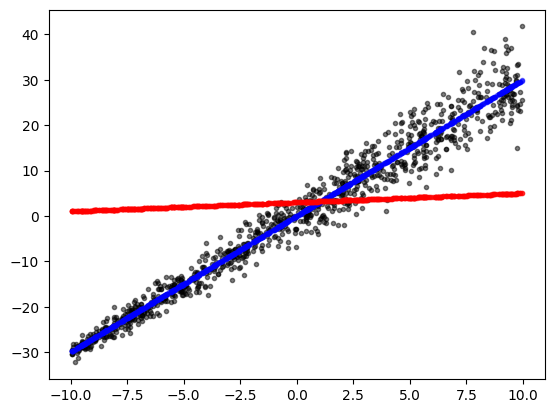

In [159]:
pyplot.plot(x, y, '.', color='black', alpha=0.5)
pyplot.plot(x, mu, '.', color='blue', alpha=0.5)
pyplot.plot(x, sigma, '.', color='red', alpha=0.5)

# build model

In [166]:
# model = torch.nn.Linear(1, 2).cuda()
model = torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 2)
).cuda()

init_weights(model)

# regression

In [167]:
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [172]:
train_x = torch.tensor(x).unsqueeze(-1).cuda().float()
train_y = torch.tensor(y).unsqueeze(-1).cuda().float()
    
model.train()

lls, sigmas, mses, val_mses = list(), list(), list(), list()

for epoch in tqdm(range(2000)):

    optimizer.zero_grad()

    mu_sigma = model(train_x)

    # backward

    ll = log_likelihood(
        mu_sigma[..., 0], mu_sigma[..., 1] ** 2, 
        train_y, 
        # eps=0.,
        clip=10.
    )

    mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], train_y[..., 0])

    loss = ll + (mu_sigma[..., 1] ** 2).mean() * 0.01 #+ mse

    loss.backward()
    optimizer.step()

    lls.append(ll.detach().cpu().numpy())
    sigmas.append(torch.abs(mu_sigma[..., 1]).mean().detach().cpu().numpy())
    mses.append(mse.detach().cpu().numpy())

  0%|          | 0/2000 [00:00<?, ?it/s]

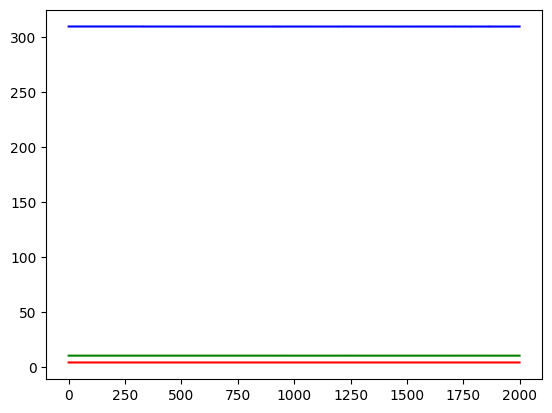

In [173]:
pyplot.plot(lls, color='red')
pyplot.plot(sigmas, color='green')
pyplot.plot(mses, color='blue')

In [174]:
pred_mu = mu_sigma[..., 0].detach().cpu().numpy()
pred_sigma = np.abs(mu_sigma[..., 1].detach().cpu().numpy())

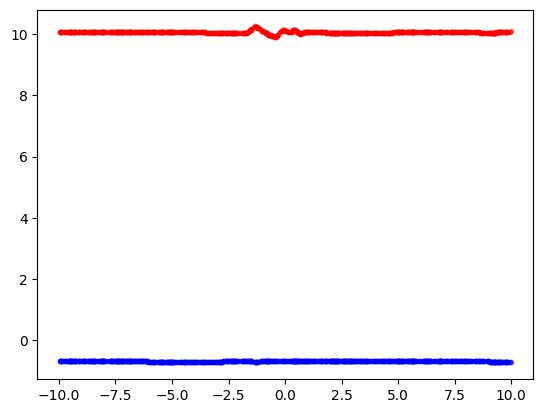

In [171]:
pyplot.plot(x, pred_mu, '.', color='blue', alpha=0.5)
pyplot.plot(x, pred_sigma, '.', color='red', alpha=0.5)